# Accuracy Summary Table

|      Base Setup     	|     	|     	|     	|         	|            	|     	|     	|     	|         	|
|:-------------------:	|-----	|-----	|-----	|---------	|------------	|-----	|-----	|-----	|---------	|
| SciKit              	|  1  	|  2  	|  3  	| Average 	| Tensorflow 	|  1  	|  2  	|  3  	| Average 	|
| K Nearest Neighbors 	| 100 	| 100 	| 100 	|   100   	| LSTM       	| 100 	| 100 	| 100 	|   100   	|
| Linear & RBF SVM    	| 100 	| 100 	| 100 	|   100   	| GRU        	| 100 	| 100 	| 100 	|   100   	|
| QDA                 	| 100 	| 100 	| 100 	|   100   	| Simple RNN 	| 100 	| 100 	| 100 	|   100   	|
| Gaussian Process    	| 100 	| 100 	| 100 	|   100   	| Bi LSTM    	| 100 	| 100 	| 100 	|   100   	|
| Decision Tree       	| 100 	| 100 	| 100 	|   100   	| Bi GRU     	| 100 	| 100 	| 100 	|   100   	|
| Random Forest       	| 100 	| 100 	| 100 	|   100   	| Bi RNN     	| 100 	| 100 	| 100 	|   100   	|
| Neural Net          	| 100 	| 100 	| 100 	|   100   	| Dense      	| 100 	| 100 	| 100 	|   100   	|
| AdaBoost            	| 100 	| 100 	| 100 	|   100   	|            	|     	|     	|     	|         	|
| Naive Bayes         	| 100 	| 100 	| 100 	|   100   	|            	|     	|     	|     	|         	|



In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import pickle 

from pprint import pprint
from tqdm import tqdm

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, minmax_scale

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.datasets import load_digits

from tensorflow.keras.callbacks import ModelCheckpoint

from scipy.ndimage import convolve

from scikeras.wrappers import KerasClassifier

from keras.utils import to_categorical

import collections 
import random

2024-05-03 14:12:05.998808: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 14:12:06.952665: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 14:12:09.018627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 14:12:12.157323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Preparation

In [2]:
FULL_DATA = False
LE = LabelEncoder()
WINDOW_LENGTH = 5
ADD_ELEMENTS = True


concatenated_data = pd.read_csv("Concatenated Data.csv")

if FULL_DATA:
    raw_dataset = concatenated_data[["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed", "sealevelpressure", "conditions"]]
else:
    raw_dataset = concatenated_data[["temp", "feelslike", "humidity", "windspeed", "sealevelpressure", "conditions"]]

raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])

t_arr = raw_dataset.copy().to_numpy()
X = []
y = []

for i in range(len(t_arr) - WINDOW_LENGTH):
    t_row = []
    for j in t_arr[i : i + WINDOW_LENGTH]:
        t_row.append(j[:-1])
    t_row = np.array(t_row).flatten()
    X.append(t_row)
    y.append(t_arr[i + WINDOW_LENGTH][-1])

X = np.array(X, "float32")
X = minmax_scale(X, feature_range=(0, 1))
y = np.array(y)

counts = dict(collections.Counter(y))
max_count = max(counts.values())

# Data Augmentation

if ADD_ELEMENTS:
    for key, value in counts.items():
        curX = []
        curY = []
        li, = np.where(y == key)
        for i in range((max_count - value) * 10):
            ci = random.choice(li)
            curX.append(X[ci])
            curY.append(y[ci])
        tX = X.tolist()
        tY = y.tolist()
        tX.extend(curX)
        tY.extend(curY)
        X = np.array(tX)
        y = np.array(tY)        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_valid.shape, y_test.shape)


/tmp/ipykernel_4721/3229338220.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
/tmp/ipykernel_4721/3229338220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])


(29372, 25) (7344, 25) (29372,) (7344,)


In [5]:
RBM_MULTIPLIER = 0.5

classifiers = [
    ("KNN", KNeighborsClassifier()),
    ("RBF SVM", SVC()),
    ("LINEAR SVM", SVC(kernel = "linear")),
    ("DECISION TREE", DecisionTreeClassifier()),
    ("RANDOM FOREST", RandomForestClassifier()),
    ("MLP", MLPClassifier()),
    ("ADA BOOST", AdaBoostClassifier()),    
    ("LOGISTIC", LogisticRegression())
]

Results = {

}

for (name, _clf) in classifiers:

    for rbm_layer in range(0, 6):
        comb = []

        comb.append((f"mms0", MinMaxScaler()))
        # Constant
        for j in range(0, rbm_layer):
            comb.append((f"rbm{j}", BernoulliRBM(n_components = int(X_train.shape[1] * RBM_MULTIPLIER), learning_rate = 0.01, n_iter = 10, verbose = 0)))

            if j == rbm_layer - 1:
                comb.append((f"mms{j}", MinMaxScaler()))


        
        comb.append((name, _clf))
        predictor = Pipeline(comb)

        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        if name not in Results:
            Results[name] = {}
        Results[name][rbm_layer] = accuracy
        print(f"{name}\tConstant\tLayer: {rbm_layer}\tAccuracy: {accuracy}")
        



KNN	Constant	Layer: 0	Accuracy: 95.35675381263616
KNN	Constant	Layer: 1	Accuracy: 94.79847494553377
KNN	Constant	Layer: 2	Accuracy: 94.44444444444444
KNN	Constant	Layer: 3	Accuracy: 94.25381263616558
KNN	Constant	Layer: 4	Accuracy: 94.14488017429193
KNN	Constant	Layer: 5	Accuracy: 93.80446623093682
RBF SVM	Constant	Layer: 0	Accuracy: 90.16884531590415
RBF SVM	Constant	Layer: 1	Accuracy: 56.495098039215684
RBF SVM	Constant	Layer: 2	Accuracy: 55.9640522875817
RBF SVM	Constant	Layer: 3	Accuracy: 51.85185185185185
RBF SVM	Constant	Layer: 4	Accuracy: 54.69771241830066
RBF SVM	Constant	Layer: 5	Accuracy: 56.03213507625272
LINEAR SVM	Constant	Layer: 0	Accuracy: 82.77505446623094
LINEAR SVM	Constant	Layer: 1	Accuracy: 53.47222222222222
LINEAR SVM	Constant	Layer: 2	Accuracy: 50.65359477124183
LINEAR SVM	Constant	Layer: 3	Accuracy: 54.47984749455338
LINEAR SVM	Constant	Layer: 4	Accuracy: 54.738562091503276
LINEAR SVM	Constant	Layer: 5	Accuracy: 55.392156862745104
DECISION TREE	Constant	Layer: 0	

c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP	Constant	Layer: 0	Accuracy: 92.08877995642702


c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP	Constant	Layer: 1	Accuracy: 57.938453159041394


c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP	Constant	Layer: 2	Accuracy: 59.912854030501094


c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP	Constant	Layer: 3	Accuracy: 57.44825708061002


c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP	Constant	Layer: 4	Accuracy: 58.55119825708061


c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP	Constant	Layer: 5	Accuracy: 53.07734204793029
ADA BOOST	Constant	Layer: 0	Accuracy: 85.23965141612202
ADA BOOST	Constant	Layer: 1	Accuracy: 79.38453159041394
ADA BOOST	Constant	Layer: 2	Accuracy: 76.93355119825708
ADA BOOST	Constant	Layer: 3	Accuracy: 69.96187363834423
ADA BOOST	Constant	Layer: 4	Accuracy: 75.12254901960785
ADA BOOST	Constant	Layer: 5	Accuracy: 72.68518518518519


c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC	Constant	Layer: 0	Accuracy: 76.10294117647058
LOGISTIC	Constant	Layer: 1	Accuracy: 56.141067538126364
LOGISTIC	Constant	Layer: 2	Accuracy: 50.885076252723316
LOGISTIC	Constant	Layer: 3	Accuracy: 54.724945533769066
LOGISTIC	Constant	Layer: 4	Accuracy: 55.392156862745104
LOGISTIC	Constant	Layer: 5	Accuracy: 57.27124183006536


In [7]:
pprint(Results)

{'ADA BOOST': {0: 85.23965141612202,
               1: 79.38453159041394,
               2: 76.93355119825708,
               3: 69.96187363834423,
               4: 75.12254901960785,
               5: 72.68518518518519},
 'DECISION TREE': {0: 97.1541394335512,
                   1: 97.18137254901961,
                   2: 96.77287581699346,
                   3: 96.70479302832244,
                   4: 96.71840958605664,
                   5: 96.50054466230938},
 'KNN': {0: 95.35675381263616,
         1: 94.79847494553377,
         2: 94.44444444444444,
         3: 94.25381263616558,
         4: 94.14488017429193,
         5: 93.80446623093682},
 'LINEAR SVM': {0: 82.77505446623094,
                1: 53.47222222222222,
                2: 50.65359477124183,
                3: 54.47984749455338,
                4: 54.738562091503276,
                5: 55.392156862745104},
 'LOGISTIC': {0: 76.10294117647058,
              1: 56.141067538126364,
              2: 50.885076252723316,
   

In [3]:
def BuildGenericModel(input_dimension, output_dimension, layerType, Kernel_Count = 64, Layer_Count = 2, Dense_Flag = False, Bidirectional_Flag = False):
    PredictorModel = Sequential()
    PredictorModel.add(layers.InputLayer((input_dimension, 1)))

    if Dense_Flag:
        # No Return Sequences for Dense Layer
        for i in range(1, Layer_Count):
            PredictorModel.add(layerType(Kernel_Count))

        # Final Layer
        PredictorModel.add(layerType(Kernel_Count))
        
    elif Bidirectional_Flag:
        # Return Sequences (Only Adds if More than 1 Layers)
        for i in range(1, Layer_Count):
            PredictorModel.add(layerType)

        # Add a Final SimpleRNN Layer at End of Bidirectional Layers
        PredictorModel.add(layers.SimpleRNN(Kernel_Count))

    else:
        # Return Sequences (Only Adds if More than 1 Layers)
        for i in range(1, Layer_Count):
            PredictorModel.add(layerType(Kernel_Count, return_sequences = True))
        
        # Final Layer
        PredictorModel.add(layerType(Kernel_Count))

    # Flatten Layer
    PredictorModel.add(layers.Flatten()) 

    # Output Dimension
    PredictorModel.add(layers.Dense(output_dimension, activation = "softmax"))

    # Compile Model
    PredictorModel.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

    return PredictorModel

def buildModels(X_train_shape, Y_train_shape, Kernel = 64, Layer_Count = 2):
    LSTMModel = BuildGenericModel(X_train_shape[1], Y_train_shape[1], layers.LSTM, Kernel, Layer_Count)
    GRUModel = BuildGenericModel(X_train_shape[1], Y_train_shape[1], layers.GRU, Kernel, Layer_Count)
    SimpleRNNModel = BuildGenericModel(X_train_shape[1], Y_train_shape[1], layers.SimpleRNN, Kernel, Layer_Count)
    BiLSTMModel = BuildGenericModel(X_train_shape[1], Y_train_shape[1], layers.Bidirectional(layers.LSTM(Kernel, return_sequences = True)), Kernel, Layer_Count, Bidirectional_Flag = True)
    BiGRUModel = BuildGenericModel(X_train_shape[1], Y_train_shape[1], layers.Bidirectional(layers.GRU(Kernel, return_sequences = True)), Kernel, Layer_Count, Bidirectional_Flag = True)
    BiSimpleRNNModel = BuildGenericModel(X_train_shape[1], Y_train_shape[1], layers.Bidirectional(layers.SimpleRNN(Kernel, return_sequences = True)), Kernel, Layer_Count, Bidirectional_Flag = True)
    DenseModel = BuildGenericModel(X_train_shape[1], Y_train_shape[1], layers.Dense, Kernel, Layer_Count, Dense_Flag = True)

    return (LSTMModel, GRUModel, SimpleRNNModel, BiLSTMModel, BiGRUModel, BiSimpleRNNModel, DenseModel)


In [4]:

tf_X_train = minmax_scale(X_train, feature_range = (0, 1))
tf_X_test = minmax_scale(X_test, feature_range = (0, 1))

tf_y_train = to_categorical(y_train)
tf_y_test = to_categorical(y_test)

LSTM_Predictor, GRU_Predictor, RNN_Predictor, Bi_LSTM_Predictor, Bi_GRU_Predictor, Bi_RNN_Predictor, Dense_Predictor = buildModels(tf_X_train.shape, tf_y_train.shape)

In [5]:
TRAIN_EPOCHS = 10
BATCH_SIZE = 1024

classifiers = [
    ("LSTM", LSTM_Predictor), 
    ("GRU", GRU_Predictor), 
    ("RNN", RNN_Predictor), 
    ("BI LSTM", Bi_LSTM_Predictor), 
    ("BI GRU", Bi_GRU_Predictor), 
    ("BI RNN", Bi_RNN_Predictor), 
    ("DENSE", Dense_Predictor)
]

Results = {}

In [6]:
RBM_MULTIPLIER = 2 

for (name, _clf) in classifiers:

    for rbm_layer in range(0, 6):
        comb = []

        comb.append((f"mms0", MinMaxScaler()))

        # Constant
        for j in range(0, rbm_layer):
            
            comb.append((f"rbm{j}", BernoulliRBM(n_components = int(X_train.shape[1] * RBM_MULTIPLIER), learning_rate = 0.01, n_iter = 10, verbose = 0)))

            if j == rbm_layer - 1:
                comb.append((f"mms1", MinMaxScaler()))

        predictor = Pipeline(comb)
        
        copy_tf_X_train = predictor.fit_transform(tf_X_train)
        

        mcp_save = ModelCheckpoint(f"{name}_Constant_Layer_{rbm_layer}.keras", save_best_only = True, monitor = "accuracy", mode = "max")
        current_model = tf.keras.models.clone_model(_clf)
        current_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
        history = current_model.fit(copy_tf_X_train, tf_y_train, batch_size = BATCH_SIZE, epochs = TRAIN_EPOCHS, callbacks = [mcp_save])
        y_pred = np.argmax(current_model.predict(tf_X_test), axis = 1)
        accuracy = accuracy_score(y_test, y_pred) * 100
        
        if name not in Results:
            Results[name] = {}
        
        Results[name][rbm_layer] = {}
        Results[name][rbm_layer]["accuracy"] = accuracy
        Results[name][rbm_layer]["history"] = history.history
        
        print(f"{name}\tConstant\tLayer: {rbm_layer}\tAccuracy: {accuracy}")
        
        
        

with open("TensorflowAccuracySaves.pkl", "wb") as f:
    pickle.dump(Results, f)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.4037 - loss: 1.2605
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4594 - loss: 1.1091
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4572 - loss: 1.1103
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.4684 - loss: 1.0973
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.4639 - loss: 1.0888
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4904 - loss: 1.0690
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.4765 - loss: 1.0655
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.4735 - loss: 1.0675
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4786 - loss: 1.0564
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.4844 - loss: 1.0335
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM	Constant	Layer: 0	Accuracy: 46.5958605664488
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/ste

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 1600, but received input with shape (None, 3200)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 50), dtype=float32)
  • training=True
  • mask=None

In [7]:
pprint(Results)

{'BI GRU': {0: {'accuracy': 79.45261437908496,
                'history': {'accuracy': [0.5532479882240295,
                                         0.6133732795715332,
                                         0.6611058115959167,
                                         0.7331812381744385,
                                         0.7777815461158752,
                                         0.8153683543205261,
                                         0.847201406955719,
                                         0.8630668520927429,
                                         0.8743020296096802,
                                         0.8494144082069397],
                            'loss': [1.0838005542755127,
                                     0.9378266334533691,
                                     0.8530462384223938,
                                     0.7580858469009399,
                                     0.6650296449661255,
                                     0.5629475712776184,
 

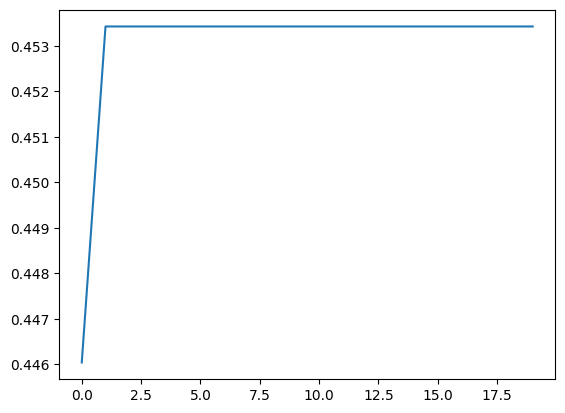

In [64]:
plt.plot(history.history["accuracy"])
plt.show()

In [65]:
y_pred = LSTMClassif.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
accuracy_score(y_pred, y_test)
# .45 - Correct RBM Size, 10 Iter
#

230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


0.45601851851851855

In [32]:
LSTMClassif.fit(X_train, y_train)
# LSTMPipe.fit(X_train, y_train)

Epoch 1/100


918/918 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.4580 - loss: 1.1095
Epoch 2/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5038 - loss: 1.0420
Epoch 3/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6517 - loss: 0.8817
Epoch 4/100
688/918 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8010 - loss: 0.5502

KeyboardInterrupt: 

In [ ]:
# y_pred = LSTMPipe.predict(X_test)
y_pred = LSTMClassif.predict(X_test)
accuracy_score(y_test, y_pred) * 100
# LSTM Only = 89%
# LSTM (10 epochs) + 1 RBM = 50.42

230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step


50.422113289760354